In [3]:
%autosave 0

Autosave disabled


### For turing users

In [4]:
# !pip install discrete-optimization-extension --extra-index-url https://pip.dsrg.fh-zwickau.de
# !pip install bias-variance-agent --extra-index-url https://pip.dsrg.fh-zwickau.de
# !pip install imblearn
# !pip install jutils with pip install --extra-index-url https://pip.dsrg.fh-zwickau.de

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from collections import defaultdict

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense

from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, SCORERS
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE

import biva
import dope
from biva.agent import Agent, Mode

# https://doc.dsrg.fh-zwickau.de/jutils/devel/
from jutils.plot import Plot
from jutils.html import HBox

import warnings
warnings.filterwarnings("ignore")

In [2]:
from biva.utils import set_gpu

In [3]:
set_gpu(per_process_gpu_memory_fraction=0.5)

Default GPU Device: /device:GPU:0



<a id="content"></a>

## Table of Contents

* [Data](#data)
* [Data preprocessing](#data_preprocess)
* [General principle](#general)
* [Usage](#usage)
    * [Define Agent](#definition)
    * [Define config](#config)
    * [Train](#train)
    * [Evaluate](#eval)
    * [Optimize](#optimize)
* [Features](#features)
    * [Data partitions](#data_partitions)
    * [Customize fit](#fit)
    * [Preprocessing optimization](#preprocessing)
    * [Custom evaluation](#evaluation)
    * [Customize scan](#Customize)
* [Examples](#examples)
* [Unbalanced data](#Unbalanced_data)

<a id="install"></a>
## [Data](#content) 

### [Bank Marketing Data Set](https://archive.ics.uci.edu/ml/datasets/bank+marketing)


<font color=green> **The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).**</font>

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).



**Data Set Information:**

You will find the data in `data/bank-full.csv`. 

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

**Attribute Information:**

`Input variables:`
#### bank client data:
+ 1 - age (numeric)
+ 2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
+ 3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
+ 4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
+ 5 - default: has credit in default? (categorical: 'no','yes','unknown')
+ 6 - housing: has housing loan? (categorical: 'no','yes','unknown')
+ 7 - loan: has personal loan? (categorical: 'no','yes','unknown')

#### related with the last contact of the current campaign:

+ 8 - contact: contact communication type (categorical: 'cellular','telephone')
+ 9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
+ 10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
+ 11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

####  other attributes:
+ 12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
+ 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
+ 14 - previous: number of contacts performed before this campaign and for this client (numeric)
+ 15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

#### social and economic context attributes

+ 16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
+ 17 - cons.price.idx: consumer price index - monthly indicator (numeric)
+ 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
+ 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
+ 20 - nr.employed: number of employees - quarterly indicator (numeric)

#### Output variable (desired target):

+ 21 - y - has the client subscribed a term deposit? (binary: 'yes','no')




<a id="data_preprocess"></a>
## [Data preprocessing](#content) 

In [4]:
from biva.preprocessing.selection import get_categorical_cols, get_numerical_cols

In [5]:
RND_SEED = 0
data = pd.read_csv('../../data/bank-full.csv', sep= ';')
# data = pd.read_csv('../datasets/lecture/bank-full.csv', sep= ';')
# data = pd.read_csv('../datasets/lecture/bank-additional-full.csv', sep=';')

# Datatype changes
data['day'] = data['day'].astype(str)

categorical = get_categorical_cols(data)
numerical = get_numerical_cols(data)
print(f'categorical cols: {categorical}')
print(f'  numerical cols: {numerical}')

# Encoding the variables
label_encoder = defaultdict(LabelEncoder)
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

df = data.copy()
df[categorical] = data[categorical].apply(lambda x: label_encoder[x.name].fit_transform(x))
df[numerical] = mm_scaler.fit_transform(df[numerical])
df["balance"] = std_scaler.fit_transform(df[["balance"]])

categorical.remove('y')

X = df.drop("y", 1)
y = df.y

categorical cols: ['loan', 'contact', 'education', 'month', 'job', 'y', 'housing', 'poutcome', 'day', 'default', 'marital']
  numerical cols: ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']


In [6]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0.519481,4,1,2,0,0.256419,1,0,2,26,8,0.053070,0.0,0.0,0.0,3,0
1,0.337662,9,2,1,0,-0.437895,1,0,2,26,8,0.030704,0.0,0.0,0.0,3,0
2,0.194805,2,1,1,0,-0.446762,1,1,2,26,8,0.015453,0.0,0.0,0.0,3,0
3,0.376623,1,1,3,0,0.047205,1,0,2,26,8,0.018707,0.0,0.0,0.0,3,0
4,0.194805,11,2,3,0,-0.447091,0,0,2,26,8,0.040260,0.0,0.0,0.0,3,0


<a id="general"></a>
# [General principle](#content) 

```python
from biva.agent import Agent

def build_model(config):
    # ... Model creation using dictionary with hyperparams config 
    return model

def fit_func(model, config, x_train, y_train, validation_data, **kwargs):
    # config - optimizible hyperparams
    # kwargs - other attrs for fit passed from train_model_on, optional
    result = model.fit(x_train, y_train, validation_data, attr1=config['attr1'], attr2=kwargs['attr2'])
    bias, variance = result['bias'], result['variance']
    return bias, variance
    
def preprocess(config, *data):
    # X and Y variables retrieval
    # Preprocessing steps with optimizible params like different thresholds for outlier detection ect.
    x, y = df.drop("y", 1), df.y
    return x, y

# Instantiate object and off we go
agnt = Agent(X, Y, preprocessing=preprocess, build_model=build_model, fit_func=fit_func)

# train model
agnt.train_model_on(**kwargs)

# optimize
agnt.scan('acs', **kwargs)
```

<a id="usage"></a>
# [1. Usage](#content) 

#### XGB example

In [7]:
from biva.agent import Agent

In [8]:
from xgboost import XGBClassifier
    
def build_model_xgb(config):
    model = XGBClassifier(**config, random_state=RND_SEED, verbosity=0)
    return model

In [9]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0.519481,4,1,2,0,0.256419,1,0,2,26,8,0.053070,0.0,0.0,0.0,3,0
1,0.337662,9,2,1,0,-0.437895,1,0,2,26,8,0.030704,0.0,0.0,0.0,3,0
2,0.194805,2,1,1,0,-0.446762,1,1,2,26,8,0.015453,0.0,0.0,0.0,3,0
3,0.376623,1,1,3,0,0.047205,1,0,2,26,8,0.018707,0.0,0.0,0.0,3,0
4,0.194805,11,2,3,0,-0.447091,0,0,2,26,8,0.040260,0.0,0.0,0.0,3,0


<a id="definition"></a>
## [1.1 Define Agent](#content) with `build_model` attibute and data.

In case of sklearn models and simple keras models this is pretty much everything we need to get going.</span>

In [10]:
agnt_xgb = Agent(X, y, build_model=build_model_xgb)

<a id="config"></a>
## [1.2 Define config](#content) dictionary that cointains hyperparameters of our model.

`config` is always passed to `build_model` function

In [11]:
config_xgb = {
    'objective': 'binary:logistic', 'tree_method':'gpu_hist', 'use_label_encoder': False
}

<a id="train"></a>
## [1.3 Train](#content) 

***train_model_on*** method is used to train and validate model on specific data partitions.\
It can be used to train model using certain model `config` to see the effect of different hyperparameters on performance or just to estimate current performance using [Hold-Out](https://vitalflux.com/hold-out-method-for-training-machine-learning-model/) method.

In [12]:
result, model = agnt_xgb.train_model_on(config_xgb)

Training on 40689 samples, testing on 4522 samples.
                     | loss       | val_loss
Training session: 1  | 9.5230e-01 | 9.1508e-01**
-----------------------------------------------
Average values:      | 9.5230e-01 | 9.1508e-01



<a id="eval"></a>
## [1.4 Evaluate](#content)

***eval_model_cv*** uses Cross-validation to estimate bias and variance.\
It applies `train_model_on` on each subset of data partitions and the averages the result. 
This is done in paralell by default. Use `parallelize` argument to change the type of computation.

```python
parallelize: str in {‘processes’, ‘threads’} or None or bool. 'threads' by default.
                     Whether to use parallel computing for training on subpartitions.
                     Also accepts soft hint as string to choose the default backend.
```

In [13]:
bias, variance = agnt_xgb.eval_model_cv(verbose=2)

5-KFold Evaluation on 40689 samples.
                   | loss       | val_loss
Data partition: 1  | 9.5493e-01 | 9.0096e-01
Data partition: 2  | 9.5456e-01 | 9.0944e-01
Data partition: 5  | 9.5524e-01 | 9.0709e-01
Data partition: 4  | 9.5601e-01 | 9.0206e-01
Data partition: 3  | 9.5671e-01 | 9.0587e-01
---------------------------------------------
Average values:    | 9.5549e-01 | 9.0508e-01



<a id="optimize"></a>
## [1.5 Optimize](#content) with *scan*

**1) Define parameter space using ```dope.Mode```**

In [14]:
from biva.agent import Mode
from biva.utils import format_parameter_space

subsample = np.linspace(0, 1, 9)
params = [
    Mode('n_estimators', values=[50, 200], mode_optimizer="gridsearch"),
    Mode('gamma',        values=[0, 1],    mode_optimizer="bayessearch", init_points=4, n_trials=3),
    Mode('subsample',    values=subsample, mode_optimizer="randomsearch", random_samples=2),
]

print(format_parameter_space(params))

'n_estimators' : [50, 200] (2), 
'gamma'        : [0, 1] (2), 
'subsample'    : [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ] (9)
Total number of grid cofigurations: 3.60e+01 | 36
Total number of acs  cofigurations: 1.30e+01 | 13


**2) Call ```Agent().scan()``` and specify search type `optimizer` of your choice.**

Different optimizers require specific arguments, but error message will let you know if somethibng is missing.\
For more info see `scan` and `dope` docs.

```python
optimizer (str): Defines type of hyperparameter search to perform.
                     Can be equal to: "acs"         : Adaptive cross search,
                                      "grid"        : Grid search
                                      "random"      : Random search,
                                      "bayes"       : Bayes search,
                                      "halving_grid": Halving grid search.
```

In [33]:
%%time
variance, bconf, model = agnt_xgb.scan('acs', parameter_space=params, config=config_xgb, strategy='max')

"iterations" positional argument is missing. Using default value: 1
"order" positional argument is missing. Using default order: ['n_estimators', 'gamma', 'subsample']
acs
# Iteration: 1

GridSearch for Hyperparameter: n_estimators
Current configuration: {'objective': binary:logistic, 'tree_method': gpu_hist, 'use_label_encoder': False, 'n_estimators': 50, 'gamma': 0, 'subsample': 0.000000e+00}
 Variance: -8.824497e-01, Bias: -8.824498e-01, HyperParams: {'n_estimators': 50}, Time: 0:00:01
 Variance: -8.824500e-01, Bias: -8.824498e-01, HyperParams: {'n_estimators': 200}, Time: 0:00:04
Max. Variance: -8.824500e-01, Best HyperParams: {'n_estimators': 200}, Time: 0:00:06

BayesSearch for Hyperparameter: gamma
Current configuration: {'objective': binary:logistic, 'tree_method': gpu_hist, 'use_label_encoder': False, 'n_estimators': 200, 'gamma': 0, 'subsample': 0.000000e+00}
 Variance: -8.824498e-01, Bias: -8.824498e-01, HyperParams: {'gamma': 2.470818e-01}, Time: 0:00:04
 Variance: -8.82449

`bconf` contains your best hyperparameters

<a id="features"></a>
# [2. Features](#content)

<a id="data_partitions"></a>
##  2.1 You can use different [data partitions](#content) for training and scanning

by specifying `data_partitions` argument.

<br>
<img src="../images/data_partitions.png" alt="Data partitions" width="500" >

***Data partition attributes:***

    train_data: Train data. Usually 80-90% of entire data.
                Used to train or evaluate model.
    train_y:    Train target data. (Might not be present)
    train_xy:   a tuple (train_data, train_y)

    test_data:  Test data. Data that model has never seen during training.
                Used for final model testing.
    test_y:     Test target data.
    test_xy:    a tuple (test_data, test_y)
    
    
    val_train_data:  Train data. 80-90% of train_data.
    val_train_y:     Train target data. 80-90% of train_y.
    val_train_xy:    a tuple (val_train_data, val_train_y)

    val_data:  Validation data. 10-20%(val_split) of train_data.
    val_y:     Validation target data. 10-20% of train_y.
    val_xy:    a tuple (val_data, val_y)

NOTE: in **train_model_on** `data_partitions` selects a *PAIR* of data partitions. One for training and one for testing.\
In **eval_model_cv**, however, we don't need a testing partitions as we are using cross-validation so it selects only one partition which is latter splitted n_fold times

Final model performance can be obtained by calling train model on the full data using ```data_partitions='full'```

In [21]:
res, model = agnt_xgb.train_model_on(config_xgb, data_partitions='full')
res, model = agnt_xgb.train_model_on(config_xgb, data_partitions='test')
res, model = agnt_xgb.train_model_on(config_xgb, data_partitions='val')

Training on 45211 samples.
                     | loss       
Training session: 1  | 9.7226e-01**
-----------------------------------------------
Average values:      | 9.7226e-01

Training on 40689 samples, testing on 4522 samples.
                     | loss       | val_loss
Training session: 1  | 9.7714e-01 | 9.1331e-01**
-----------------------------------------------
Average values:      | 9.7714e-01 | 9.1331e-01

Training on 36620 samples, testing on 4069 samples.
                     | loss       | val_loss
Training session: 1  | 9.7914e-01 | 9.7125e-01**
-----------------------------------------------
Average values:      | 9.7914e-01 | 9.7125e-01



In [22]:
bias, var = agnt_xgb.eval_model_cv(config_xgb, data_partitions='full')
bias, var = agnt_xgb.eval_model_cv(config_xgb, data_partitions='test')
bias, var = agnt_xgb.eval_model_cv(config_xgb, data_partitions='val')

5-KFold Evaluation on 45211 samples.
                   | loss       | val_loss
---------------------------------------------
Average values:    | 9.7968e-01 | 9.0330e-01

5-KFold Evaluation on 4522 samples.
                   | loss       | val_loss
---------------------------------------------
Average values:    | 9.9939e-01 | 8.9783e-01

5-KFold Evaluation on 4069 samples.
                   | loss       | val_loss
---------------------------------------------
Average values:    | 9.9951e-01 | 8.9383e-01



<a id="fit"></a>
## 2.2 Customize [fit](#content)  function

In [23]:
def loss_(true, pred, thresh=5/7):
    pred_label = np.where(pred > 5/7, 1, 0)  
    loss = np.int16((true==1)&(pred_label==0)) * 5 * (1 - pred)\
        + np.int16((true==0)&(pred_label==1)) * 25 * pred\
        + np.int16((true==1)&(pred_label==1)) * (-5) * pred
    return np.sum(loss)

def get_loss(model, data, thresh=5/7):
    y_pred = model.predict_proba(data[0])[:, 1]
    return loss_(data[1], y_pred)

# Fit function must take following arguments and return a tuple (bias, variance)
def fit(model, config, train_data, test_data, **kwargs):
    try:
        model.fit(*train_data)
    except ValueError:
        return np.inf, np.inf
    
    loss = get_loss(model, train_data)
    if test_data is not None:
        val_loss = get_loss(model, test_data)
        return loss, val_loss
    else:
        return loss, None

In [24]:
agnt_xgb = Agent(X, y, build_model=build_model_xgb, fit_func=fit)
result, model = agnt_xgb.train_model_on(config_xgb, data_partitions='test')

Training on 40689 samples, testing on 4522 samples.
                     | loss       | val_loss
Training session: 1  | -7.8781e+03 | 2.6015e+03**
------------------------------------------------
Average values:      | -7.8781e+03 | 2.6015e+03



<a id="preprocessing"></a>
## 2.3 Optimize parameters for [preprocessing step](#content).

In [15]:
pdays_contacted = data.pdays[data.pdays != -1].to_frame()
pdays_contacted.hist(bins=20)

std_ = pdays_contacted.describe().loc['std']

HBox( [ Plot(), pdays_contacted.describe() ], css = { 'height': '20em', 'column-gap': '1em' } )

,pdays
count,8257.000000
mean,224.577692
std,115.344035
min,1.000000
25%,133.000000
50%,194.000000
75%,327.000000
max,871.000000


In [16]:
def feature_transform(config, x):
    if config.get('one_hot_encode', False):
        x = pd.get_dummies(x, columns=categorical)

    if config.get('new_features', False):
        x["recall"] = x.pdays.apply(lambda el: 0 if (el == -1) or (el == 0) else 1 / el)
        x['attention'] = x.duration * x.campaign
        x['recognition'] = x.attention * x.recall
        x['importance'] = x.recognition * x.balance
    
    return x

In [17]:
# The number of attributes you need to pass after `config` depends on how many data arguments you pass to the Agent()
def preprocessing(config: dict, x, y):     
    x = x.copy()  # to prevent change of values in the initial dataset
    x = feature_transform(config, x)
    
    if config.get('print_prepr', False): print(f'doing preprocessing on {x.shape[0]} samples')
    return x, y

build_model_xgb = lambda x: XGBClassifier(**x, verbosity=0, use_label_encoder=False)

# Not
agnt = Agent(X, y, build_model=build_model_xgb, preprocessing=preprocessing)

### OR

In [18]:
def preprocessing(config: dict, df):
    y = df.y
    x = df.iloc[:, :-1]
    x = feature_transform(config, x)
    
    if config.get('print_prepr', False): print(f'doing preprocessing on {x.shape[0]} samples')
    return x, y

agnt = Agent(df, build_model=build_model_xgb, preprocessing=preprocessing)

### Base case: all preprocessing keys are set to False

In [19]:
config_xgb = {
    'n_estimators': 128, 'subsample': 1.0, 'learning_rate': 0.2, 
    'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.9, 'colsample_bytree': 0.6,
    'one_hot_encode': False,
    'new_features': False,
}

bias, var = agnt.eval_model_cv(config_xgb, data_partitions='test')

5-KFold Evaluation on 4522 samples.
                   | loss       | val_loss
---------------------------------------------
Average values:    | 9.7075e-01 | 9.0734e-01



In [21]:
from dope.method import Mode

params = [
    Mode('one_hot_encode', [0, 1]),
    Mode('new_features',   [0, 1]),
]

var, conf, model = agnt.scan('grid', parameter_space=params, config=config_xgb, strategy='max')

grid for Hyperparameter: one_hot_encode, new_features
Current configuration: {'n_estimators': 128, 'subsample': 1.000000e+00, 'learning_rate': 2.000000e-01, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 9.000000e-01, 'colsample_bytree': 6.000000e-01, 'one_hot_encode': 0, 'new_features': 0}
 Variance: -9.074688e-01, Bias: -9.232839e-01, HyperParams: {'one_hot_encode': 0, 'new_features': 0}, Time: 0:00:02
 Variance: -9.063874e-01, Bias: -9.234990e-01, HyperParams: {'one_hot_encode': 0, 'new_features': 1}, Time: 0:00:02
 Variance: -9.070510e-01, Bias: -9.237263e-01, HyperParams: {'one_hot_encode': 1, 'new_features': 0}, Time: 0:00:06
 Variance: -9.067314e-01, Bias: -9.247094e-01, HyperParams: {'one_hot_encode': 1, 'new_features': 1}, Time: 0:00:06
Max. Variance: -9.074688e-01, Best HyperParams: {'one_hot_encode': 0, 'new_features': 0}, Time: 0:00:17

Best config: {'n_estimators': 128, 'subsample': 1.0, 'learning_rate': 0.2, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.9, 'colsample

### During cross-validation evaluation you can perform preprocessing once before the splitting of the data into subpartitions or on each of the data partitions n_splits times after the split.

Use `preprocess_before_split` argument to specify the order.

In [22]:
%%time
config_xgb = {
    'n_estimators': 128, 'subsample': 1.0, 'learning_rate': 0.2, 
    'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.9, 'colsample_bytree': 0.6,
    'one_hot_encode': True, 'new_features': True, 'print_prepr': True
}
bias, var = agnt.eval_model_cv(config_xgb, verbose=2, data_partitions='test', preprocess_before_split=False, parallelize=False)

5-KFold Evaluation on 4522 samples.
                   | loss       | val_loss
doing preprocessing on 3617 samples
doing preprocessing on 905 samples
Data partition: 1  | 9.7125e-01 | 9.0387e-01
doing preprocessing on 3617 samples
doing preprocessing on 905 samples
Data partition: 2  | 9.6323e-01 | 9.1271e-01
doing preprocessing on 3618 samples
doing preprocessing on 904 samples
Data partition: 3  | 9.6877e-01 | 9.1261e-01
doing preprocessing on 3618 samples
doing preprocessing on 904 samples
Data partition: 4  | 9.6904e-01 | 8.9934e-01
doing preprocessing on 3618 samples
doing preprocessing on 904 samples
Data partition: 5  | 9.7043e-01 | 9.0597e-01
---------------------------------------------
Average values:    | 9.6854e-01 | 9.0690e-01

Wall time: 2.61 s


In [26]:
%%time
bias, var = agnt.eval_model_cv(config_xgb, verbose=2, data_partitions='test', preprocess_before_split=True, parallelize=False)

doing preprocessing on 4522 samples
5-KFold Evaluation on 4522 samples.
                   | loss       | val_loss
Data partition: 1  | 9.7014e-01 | 8.9724e-01
Data partition: 2  | 9.6959e-01 | 9.0055e-01
Data partition: 3  | 9.6600e-01 | 9.0487e-01
Data partition: 4  | 9.7291e-01 | 9.0819e-01
Data partition: 5  | 9.6739e-01 | 9.1372e-01
---------------------------------------------
Average values:    | 9.6921e-01 | 9.0491e-01

Wall time: 2.41 s


<a id="evaluation"></a>
## 2.4 Define [custom evaluation](#content) methods. 

##### However you should keep in mind that you need to pass the data you want to use for evaluation too.

In [34]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RND_SEED)

def eval_xgb(config, cv=5, scoring='roc_auc'):
    model = build_model_xgb(config)
    cv_results = cross_validate(model, x_train, y_train, cv=cv, n_jobs=-1, scoring=scoring, return_train_score=True)
    
    # Here we use the worst loss of all partitions for example
    return -(cv_results['train_score'].min()), -(cv_results['test_score'].min()), model

params = [
    Mode('n_estimators', values=[50, 500], mode_optimizer="gridsearch"),
]

In [35]:
var, conf, model = Agent().scan('grid', parameter_space=params, eval_func=eval_xgb, strategy='max')
var, conf

grid for Hyperparameter: n_estimators
Current configuration: {'n_estimators': 50}
 Variance: -9.223162e-01, Bias: -9.658271e-01, HyperParams: {'n_estimators': 50}, Time: 0:00:03
 Variance: -9.138951e-01, Bias: -9.999216e-01, HyperParams: {'n_estimators': 500}, Time: 0:00:18
Max. Variance: -9.223162e-01, Best HyperParams: {'n_estimators': 50}, Time: 0:00:22

Best config: {'n_estimators': 50}


(-0.9223162251425927, {'n_estimators': 50})

<a id="Customize"></a>
##  2.5 [Customize](#content) your scan: 
* maximize or minimize target value with `strategy` argument
* select target value for optimization with `target`: {'bias', 'variance'}
* different metrics with `scoring` argument for model evaluation (sklearn models).
* `early_preprocessing` argument is used to specify when to use preprocessing on data. 
   `True` executes preprocessing function before data splitting in complementary partitions for cross validation, `False` - after, just before fit_func 
* customize outuput with `output_names` argument. See more in scan docstring


<font size=3>Agent uses default scoring parameter for particular model. This is `accurasy` for xgb, for example.<br></br>
    See available metrics for sklearn models [here](https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules).</span>


In [36]:
res, model = agnt_xgb.train_model_on(config_xgb, data_partitions='test', scoring='roc_auc')

Training on 40689 samples, testing on 4522 samples.
                     | roc_auc    | val_roc_auc
Training session: 1  | 9.9418e-01 | 9.3480e-01**
-----------------------------------------------
Average values:      | 9.9418e-01 | 9.3480e-01



In [38]:
out_names = {
    "mode_var": "Hyperparameter",
    "pivot_point": "Current config",
    "refer_val": "neg roc auc",
    "target_val": "neg roc auc",
    "mode_arg": "HyperParams",
    "minimum": "Best config",
}

_, _, _ = agnt_xgb.scan('random', parameter_space=params, random_samples=2, 
                        scoring='roc_auc', strategy='max', output_names=out_names)

random for Hyperparameter: n_estimators
Current config: {'n_estimators': 50}
 neg roc auc: -9.076408e-01, neg roc auc: -9.399223e-01, HyperParams: {'n_estimators': 50}, Time: 0:00:01
 neg roc auc: -9.031680e-01, neg roc auc: -9.979294e-01, HyperParams: {'n_estimators': 500}, Time: 0:00:14
Max. Variance: -9.076408e-01, Best HyperParams: {'n_estimators': 50}, Time: 0:00:16

Best config: {'n_estimators': 50}


<a id="examples"></a>
# [3. Examples](#content).

### Lets say we want to train model on resampled data and test on original data

In [39]:
# Instanciate Agent as a data_container object to split the data
data_container = Agent(X, y, val_split=0.2, random_seed=RND_SEED)

# Prepare original data
train_xy = data_container.train_xy
test_xy = data_container.test_xy

print(f'{train_xy[0].shape[0]} train samples')
print(f'{test_xy[0].shape[0]} test samples')

# Resampling
smote = SMOTE(random_state=RND_SEED)
X_res, y_res = smote.fit_resample(*train_xy)

print(f"#Yes: {sum(y_res)} | #No: {sum(~y_res+2)}")

36168 train samples
9043 test samples
#Yes: 31942 | #No: 31942


In [40]:
from xgboost import XGBClassifier

def build_model_xgb(config):
    return XGBClassifier(**config, random_state=RND_SEED)

agnt = Agent(*train_xy, build_model=build_model_xgb, random_seed=RND_SEED)

In [41]:
config = {'n_estimators':100, 'subsample': 1.0, 'learning_rate': 0.2, 'min_child_weight': 10, 
          'max_depth': 6, 'gamma': 1, 'colsample_bytree': 0.6, 'eval_metric': 'logloss'}

res, model = agnt.train_model_on(config, validation_mode='full', test_data=test_xy)

Training on 32551 samples, testing on 9043 samples.
                     | loss       | val_loss
Training session: 1  | 9.3358e-01 | 8.9981e-01**
-----------------------------------------------
Average values:      | 9.3358e-01 | 8.9981e-01



## Keras

We need to create X with one-hot-encoded categorical variables

In [42]:
X_res_enc = pd.get_dummies(X_res, columns=categorical)
X_res_enc.shape

(63884, 81)

In [43]:
from biva.utils.plotters import plot_epochs

In [44]:
metrics=['acc']

def build_model_keras(config):
    model = Sequential()
    model.add(Dense(config['denseLayer1'], activation=config['actFuncL1'], input_dim=X_res_enc.shape[1]))
    model.add(Dense(config['denseLayer2'], activation=config['actFuncL2']))
    model.add(Flatten())
    model.add(Dense(1, activation=config['actFuncLast']))
    
    lm = tf.keras.optimizers.Adadelta(lr=config['lr'])
    model.compile(loss="binary_crossentropy", optimizer=lm, metrics=metrics)
    return model

config_keras = {
    'denseLayer1': 256, 'actFuncL1': 'elu',
    'denseLayer2': 256, 'actFuncL2': 'elu',
    'actFuncLast': 'sigmoid', 
    'epochs': 5, 'batch_size': 512,
    'lr': 0.01, 'beta_1': 0.85}

In [45]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0005, patience=4)]
agent = Agent(X_res_enc, y_res, build_model=build_model_keras, callbacks=callbacks)

Training on 57495 samples, testing on 6389 samples.
                     | loss       | val_loss
Training session: 1  | 4.1629e-01 | 4.2283e-01**
Training session: 2  | 4.0522e-01 | 4.1218e-01**
Training session: 3  | 4.1169e-01 | 4.1815e-01
-----------------------------------------------
Average values:      | 4.1107e-01 | 4.1772e-01



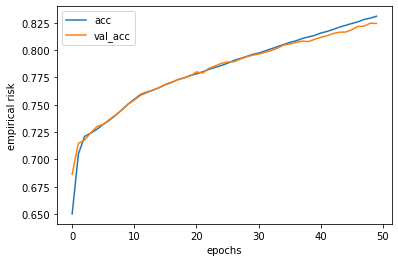

Wall time: 1min 30s


In [29]:
%%time
log, model = agent.train_model_on(config_keras, n_trainings=3, epochs=50, batch_size=512)
plot_epochs(log, metrics)

**You can also change the metric output name in output and criterion for the training.**

Training on 57495 samples, testing on 6389 samples.
                     | mse        | val_mse
Training session: 1  | 4.1085e-01 | 4.1764e-01**
-----------------------------------------------
Average values:      | 4.1085e-01 | 4.1764e-01



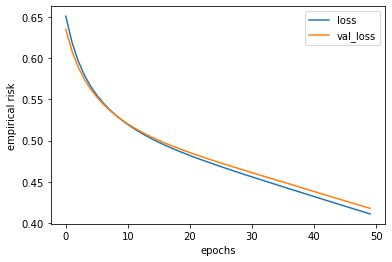

Wall time: 20.8 s


In [27]:
%%time
log, model = agent.train_model_on(config_keras, n_trainings=1, 
                                  epochs=50, batch_size=512, 
                                  target='variance', metric_name='mse', verbose=0)
plot_epochs(log)

In [47]:
neurons = [Mode(f'denseLayer{i}', [64, 128, 256]) for i in range(1, 2)]

var, bconf, model = agent.scan('acs', neurons, config_keras, iterations=1)

"order" positional argument is missing. Using default order: ['denseLayer1']
acs
# Iteration: 1

GridSearch for Hyperparameter: denseLayer1
Current configuration: {'denseLayer1': 256, 'actFuncL1': elu, 'denseLayer2': 256, 'actFuncL2': elu, 'actFuncLast': sigmoid, 'epochs': 5, 'batch_size': 512, 'lr': 1.000000e-02, 'beta_1': 8.500000e-01}
 Variance: 6.071956e-01, Bias: 6.128790e-01, HyperParams: {'denseLayer1': 64}, Time: 0:00:09
 Variance: 5.888190e-01, Bias: 5.958066e-01, HyperParams: {'denseLayer1': 128}, Time: 0:00:10
 Variance: 5.664356e-01, Bias: 5.719845e-01, HyperParams: {'denseLayer1': 256}, Time: 0:00:12
Min. Variance: 5.664356e-01, Best HyperParams: {'denseLayer1': 256}, Time: 0:00:32

Best config: {'denseLayer1': 256, 'actFuncL1': 'elu', 'denseLayer2': 256, 'actFuncL2': 'elu', 'actFuncLast': 'sigmoid', 'epochs': 5, 'batch_size': 512, 'lr': 0.01, 'beta_1': 0.85}
time elapsed: 0:00:32


In [34]:
%%time
bconf = {'denseLayer1': 256, 'actFuncL1': 'relu', 'denseLayer2': 64, 'actFuncL2': 'relu', 
         'actFuncLast': 'sigmoid', 'lr': 0.09539879737836925, 'beta_1': 0.85}

log, model = agent.train_model_on(bconf, data_partitions='test', epochs=50, batch_size=512)

Training on 57495 samples, testing on 6389 samples.
                     | loss       | val_loss
Epoch 1/50
450/450 [==============================] - 1s 3ms/step - loss: 0.5582 - acc: 0.7199 - val_loss: 0.4912 - val_acc: 0.7687
Epoch 2/50
450/450 [==============================] - 2s 3ms/step - loss: 0.4615 - acc: 0.7897 - val_loss: 0.4410 - val_acc: 0.8086
Epoch 3/50
450/450 [==============================] - 2s 4ms/step - loss: 0.4113 - acc: 0.8241 - val_loss: 0.3949 - val_acc: 0.8369
Epoch 4/50
450/450 [==============================] - 2s 4ms/step - loss: 0.3673 - acc: 0.8523 - val_loss: 0.3558 - val_acc: 0.8569
Epoch 5/50
450/450 [==============================] - 2s 4ms/step - loss: 0.3352 - acc: 0.8700 - val_loss: 0.3306 - val_acc: 0.8695
Epoch 6/50
450/450 [==============================] - 2s 4ms/step - loss: 0.3154 - acc: 0.8797 - val_loss: 0.3162 - val_acc: 0.8731
Epoch 7/50
450/450 [==============================] - 2s 4ms/step - loss: 0.3037 - acc: 0.8840 - val_loss: 0.31

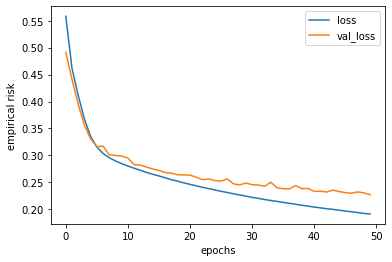

In [35]:
plot_epochs(log)

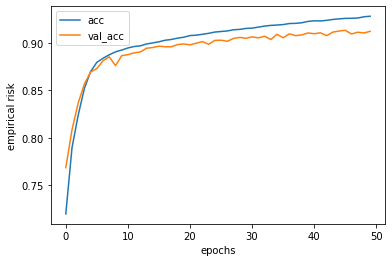

In [36]:
plot_epochs(log, ['acc'])

## Decision Trees

In [48]:
from sklearn.linear_model import LogisticRegression

def build_model_logregr(config):
    # Notice that I don't use random_state=RND_SEED now.
    return LogisticRegression(**config)

In [49]:
agnt_logr = Agent(X_res, y_res, build_model=build_model_logregr)

In [50]:
config_logregr = dict(C=0.001, penalty='l2', random_state=1)
agnt_logr.train_model_on(config_logregr, print_sessions=True)

Training on 57495 samples, testing on 6389 samples.
                     | loss       | val_loss
Training session: 1  | 7.1620e-01 | 7.0997e-01**
-----------------------------------------------
Average values:      | 7.1620e-01 | 7.0997e-01



((0.7162014088181581, 0.7099702613867584),
 LogisticRegression(C=0.001, random_state=1))

In [51]:
from biva.utils import dict_to_param_space

In [57]:
params = {"C":       np.logspace(-3,3,7), 
          "penalty": ['l2', 'none']}

params = dict_to_param_space(params)
print(format_parameter_space(params))

'C'       : [1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03] (7), 
'penalty' : ['l2', 'none'] (2)
Total number of grid cofigurations: 1.40e+01 | 14
Total number of acs  cofigurations: 9.00e+00 | 9


In [58]:
var, bconf_logregr, logreger, = agnt_logr.scan('random', params, random_samples=5)
bconf_logregr

random for Hyperparameter: C, penalty
Current configuration: {'C': 1.000000e-03, 'penalty': l2}
 Variance: 8.393947e-01, Bias: 8.388208e-01, HyperParams: {'C': 1.000000e+03, 'penalty': none}, Time: 0:00:01
 Variance: 8.366988e-01, Bias: 8.367641e-01, HyperParams: {'C': 1.000000e+01, 'penalty': l2}, Time: 0:00:01
 Variance: 8.406644e-01, Bias: 8.417688e-01, HyperParams: {'C': 1.000000e+00, 'penalty': none}, Time: 0:00:01
 Variance: 8.411340e-01, Bias: 8.410688e-01, HyperParams: {'C': 1.000000e+01, 'penalty': none}, Time: 0:00:01
 Variance: 8.360553e-01, Bias: 8.361379e-01, HyperParams: {'C': 1.000000e-02, 'penalty': none}, Time: 0:00:01
Min. Variance: 8.360553e-01, Best HyperParams: {'C': 0.01, 'penalty': 'none'}, Time: 0:00:06

Best config: {'C': 0.01, 'penalty': 'none'}


{'C': 0.01, 'penalty': 'none'}

##### Scoring parameter can be passed for any sklear model.

In [59]:
res, model = agnt_logr.train_model_on(bconf_logregr, scoring='adjusted_rand_score')

Training on 57495 samples, testing on 6389 samples.
                     | adjusted_rand_score | val_adjusted_rand_score
Training session: 1  | 4.7526e-01 | 4.6327e-01**
-----------------------------------------------
Average values:      | 4.7526e-01 | 4.6327e-01



<a id="Unbalanced_data"></a>
## [Unbalanced data](#content)

###### Don't forget to pass a correct input shape

In [15]:
from sklearn.model_selection import StratifiedKFold

def build_model_keras(config):
    model = Sequential()
    model.add(Dense(config['denseLayer1'], activation=config['actFuncL1'], input_dim=X.shape[1]))
    model.add(Dense(config['denseLayer2'], activation=config['actFuncL2']))
    model.add(Flatten())
    model.add(Dense(1, activation=config['actFuncLast']))
    lm = tf.keras.optimizers.Adadelta(lr=config['lr'])
    model.compile(loss="binary_crossentropy", optimizer=lm, metrics=['acc'])
    return model

Use `stratify` argument to split the data into partitions in a stratified fashion for unbalanced data.\
You could also pass a `StratifiedKFold` to a `splitter` argument to improve cross-validation.

In [23]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=3)]
sfold = StratifiedKFold(5)
# 
agent = Agent(X, y, build_model=build_model_keras, callbacks=callbacks, stratify=True, splitter=sfold, val_split=0.05)

In [24]:
%%time
bconf = {'denseLayer1': 256, 'actFuncL1': 'relu', 'denseLayer2': 64, 'actFuncL2': 'relu', 
         'actFuncLast': 'sigmoid', 'epochs': 5, 'lr': 0.09539879737836925, 'beta_1': 0.85}

log, model = agent.train_model_on(bconf, n_trainings=2, data_partitions='test', target='variance', epochs=500, batch_size=256)

Training on 42950 samples, testing on 2261 samples.
                     | loss       | val_loss
Training session: 1  | 2.4589e-01 | 2.3991e-01**
Training session: 2  | 2.4205e-01 | 2.3147e-01**
-----------------------------------------------
Average values:      | 2.4397e-01 | 2.3569e-01

Wall time: 49 s


In [27]:
from biva.utils.metrics import confusion_matrix_by_threshold
from biva.utils.plotters import plot_confusion_matrix

Now let's test on our test data

**Default confusion metrics (thresh=0.5)**

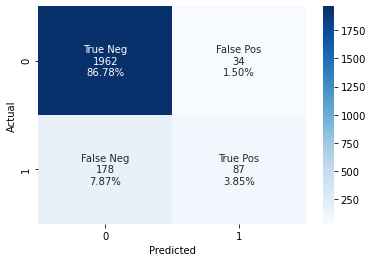

In [31]:
y_pred = model.predict(agent.test_data)
y_true = agent.test_y
cmat = confusion_matrix_by_threshold(y_true, y_pred)
plot_confusion_matrix(cmat)

**Context**

* **True positive** - client subscribed a term deposit just as predicted. Income. (**maximize**)
* **False positive** - client did not subscribe to a term deposit just as predicted, so we might as well haven't wasted our time.(**maximize**)
* **False negative** - predicted that client *would not* subscribe, but he actually would! Income waste. (**minimize**)
* **False positive** - predicted that client *would* subscribe, but he didn't. Time waste.

So taken into account our group sizes and that we want to maximize icome and minimise time wasted we conclude that **tp**, **tn** and **fn** are of key importance.

In [32]:
from biva.utils.metrics import classification_metrics, classification_metrics_by_threshold, get_best_thres
from biva.utils.plotters import plot_metrics_per_threshold

In [33]:
mbt = classification_metrics_by_threshold(y_true, y_pred)
mbt

,accuracy,precision,recall,f1_score,f2_score,roc_auc,matthews_corrcoef,cohen_kappa,true_positive_rate,true_negative_rate,positive_predictive_value,negative_predictive_value,false_positive_rate,false_negative_rate,false_discovery_rate,threshold
0,0.287483,0.141258,1.000000,0.247548,0.451294,0.596443,0.165066,0.053048,1.000000,0.192886,0.141258,1.000000,0.807114,0.000000,0.858742,0.01
1,0.455108,0.176589,0.996226,0.300000,0.516634,0.689746,0.257912,0.125967,0.996226,0.383267,0.176589,0.998695,0.616733,0.003774,0.823411,0.02
2,0.561256,0.208032,0.977358,0.343046,0.561822,0.741685,0.312573,0.185657,0.977358,0.506012,0.208032,0.994094,0.493988,0.022642,0.791968,0.03
3,0.629368,0.235457,0.962264,0.378338,0.594960,0.773717,0.352491,0.234098,0.962264,0.585170,0.235457,0.991511,0.414830,0.037736,0.764543,0.04
4,0.675807,0.256757,0.932075,0.402608,0.610781,0.786930,0.373350,0.268096,0.932075,0.641784,0.256757,0.986143,0.358216,0.067925,0.743243,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.883680,1.000000,0.007547,0.014981,0.009416,0.503774,0.081661,0.013249,0.007547,1.000000,1.000000,0.883577,0.000000,0.992453,0.000000,0.95
95,0.883238,1.000000,0.003774,0.007519,0.004713,0.501887,0.057730,0.006643,0.003774,1.000000,1.000000,0.883186,0.000000,0.996226,0.000000,0.96
96,0.883238,1.000000,0.003774,0.007519,0.004713,0.501887,0.057730,0.006643,0.003774,1.000000,1.000000,0.883186,0.000000,0.996226,0.000000,0.97
97,0.882795,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,1.000000,NaN,0.882795,0.000000,1.000000,NaN,0.98


**Best confusion matrix**

In [34]:
thr, metric = get_best_thres(mbt, 'matthews_corrcoef')
thr, metric

(0.19, 0.5388840476048409)

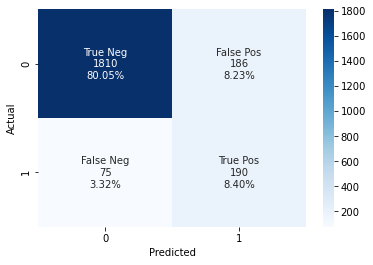

In [37]:
y_pred = model.predict(agent.test_data)
y_true = agent.test_y
cmat = confusion_matrix_by_threshold(y_true, y_pred, thr)
plot_confusion_matrix(cmat)

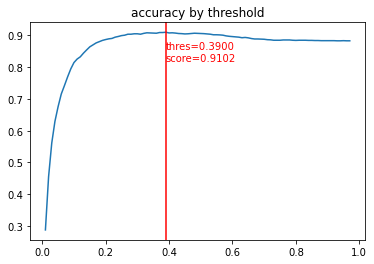

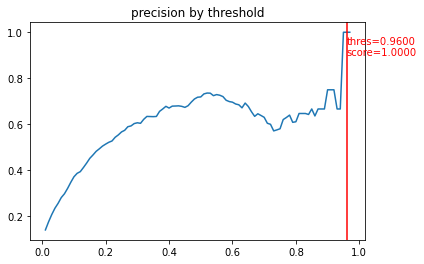

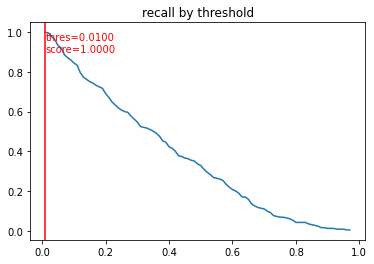

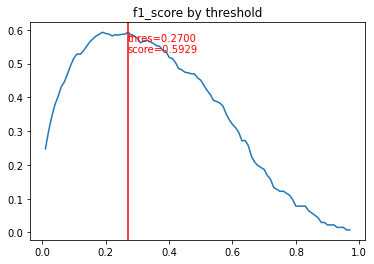

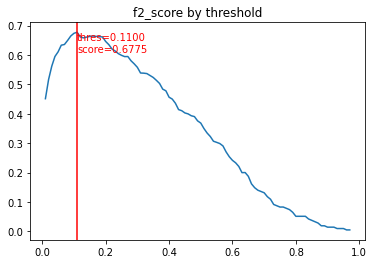

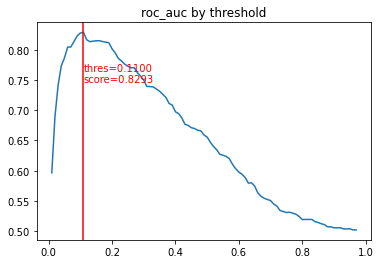

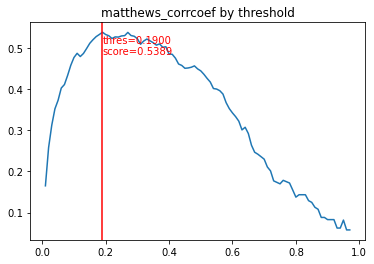

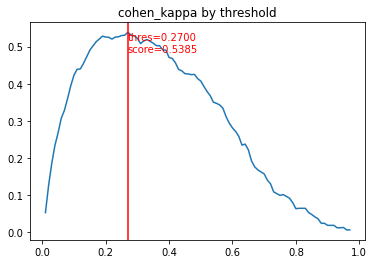

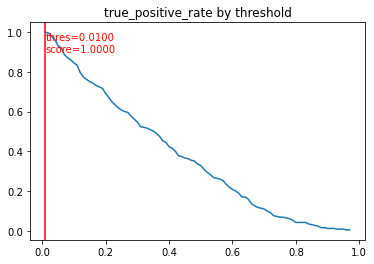

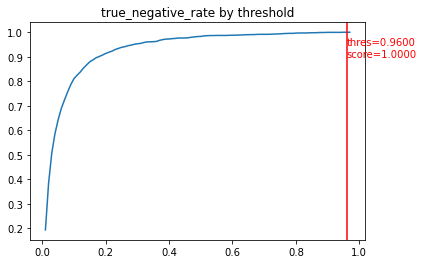

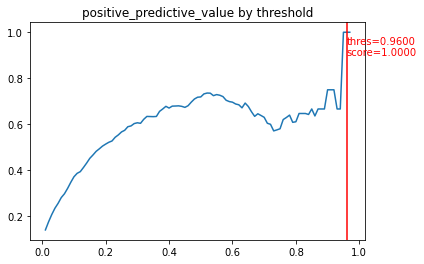

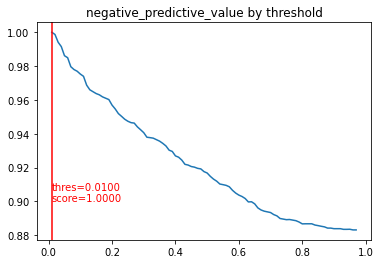

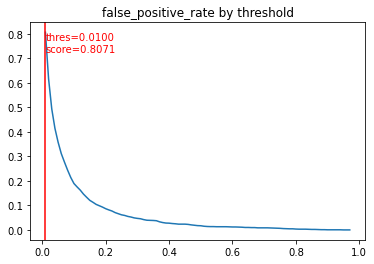

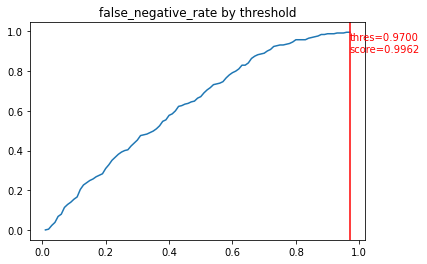

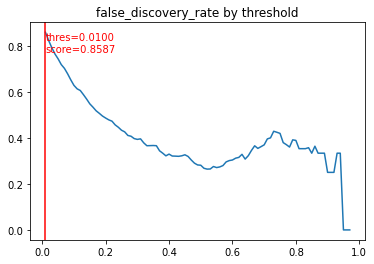

In [38]:
plot_metrics_per_threshold(y_true, y_pred)
plt.show()